<a href="https://colab.research.google.com/github/swoo-nam/project_final_team1/blob/main/%EC%9D%B4%EC%86%8C%ED%98%84_%EB%82%A8%EC%83%81%EC%9A%B0_%EC%9E%84%EC%8B%9C%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%A0%84%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
from torch import optim
from torch import optim

import warnings
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

DATA_PATH = "/content/drive/MyDrive/Final_Project/data/cluster/"
SEED = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# 데이터 불러오기

In [110]:
pd.read_csv(f"{DATA_PATH}service1_9000_9000.csv").head(3)

,review,reply,sentiment
0,"맛이 별로였어요, 조리 상태도 별로였고 배달 시간도 오래 걸렸네요","안녕하세요~! 맛이 별로였다고 하셨는데, 제 기준에는 싱겁고 딱히 맛있어 보이지 않...",0
1,양도 많고 맛나요,하핫 정말 이런 이런 칭찬에 춤추고 싶네요 든든한 생각나실 때 또 만나요 친절한 고...,1
2,음식의 퀄리티가 낮아서 별로였어요. 맛이 없어서 실망했어요,음식의 퀄리티가 낮아서 실망하셨다니 정말 죄송합니다. 더 맛있는 음식으로 만족스러운...,0


In [111]:
train = pd.read_csv(f"{DATA_PATH}service1_9000_9000.csv")
train.isnull().sum()

review       0
reply        0
sentiment    0
dtype: int64

In [112]:
train['sentiment'].value_counts().sort_index() # 긍부정 분포 확인

0    9205
1    9205
Name: sentiment, dtype: int64

### 단문 데이터 제거
- 데이터 정제 과정에서 무의미해진 데이터는 학습데이터로 사용불가
    - 리뷰 : 공백만 생겼거나, 리뷰 이벤트를 위한 단답형 제거

In [113]:
train[(train['review'].str.len() > 4) & (train['review'].str.len() <= 10)] # 리뷰

,review,reply,sentiment
1,양도 많고 맛나요,하핫 정말 이런 이런 칭찬에 춤추고 싶네요 든든한 생각나실 때 또 만나요 친절한 고...,1
166,맛있어요 와플 추천,추천해 주셔서 감사합니다 맛있다는 말씀은 언제 들어도 설레는 것 같습니다 더욱더 연...,1
251,정말 맛있었습니다,주문을 통해 한걸음 가까워진 것 같아 기분이 좋아요 1 고객을 생각하는 마음 2 더...,1
256,맛있어서 2번 시킴,감사합니다 항상 좋은 재료로 음식을 만들겠습니다 안심하셔도 됩니다 더 좋은 모습으로...,1
357,양도 많고 맛있어요,좋은 재료를 사용하고 고객님께 좋은 평가 들으며 행복을 느낍니다 고객님들 맛있게 드...,1
...,...,...,...
18150,맛있게 먹었습니다,저희 항정살 맛있게 잘 드시고 소중한 리뷰도 남겨 주셔서 너무 기쁘고 보람됩니다 저...,1
18164,맛있어요 괜찮아요,건강한 한 끼 저렴하지만 맛있게 만들겠습니다 저희 찾아주셔서 감사합니다,1
18178,맛이 너무 없어요.,불편을 드려 대단히 죄송합니다. 귀중한 의견 감사드립니다.,0
18197,맛있어요 2번째임,감사합니다 부탁드려요 진심으로 밈 맘에 들었다면 찜 부탁드립니다,1


In [114]:
len(train[train['review'].str.len() <= 10])

269

In [115]:
train = train[train['review'].str.len() > 10]
train

,review,reply,sentiment
0,"맛이 별로였어요, 조리 상태도 별로였고 배달 시간도 오래 걸렸네요","안녕하세요~! 맛이 별로였다고 하셨는데, 제 기준에는 싱겁고 딱히 맛있어 보이지 않...",0
2,음식의 퀄리티가 낮아서 별로였어요. 맛이 없어서 실망했어요,음식의 퀄리티가 낮아서 실망하셨다니 정말 죄송합니다. 더 맛있는 음식으로 만족스러운...,0
3,리뷰가 좋아서 주문했는데 정말 맛있게 잘 먹었습니다 다 맛있어요 김밥 완전 빅 사이...,감사합니다 언제나 푸짐한 양과 맛있는 맛으로 찾아뵙겠습니다 자주 애용해 주세요,1
4,항상 맛있게 잘 먹고 있습니다,고객님 소중한 고객님이 이임 항상 찾아주시고 맛있게 드셔주시니 너어어어무 기쁘고 행...,1
5,음식이 맛이 없어서 좀 아쉬웠어요. 다음에는 다른 음식점에서 시켜야겠어요,저희 음식이 맛이 없어서 아쉬움을 드렸군요. 다음에는 고객님께 맛있는 음식을 제공할...,0
...,...,...,...
18405,친구시켜줬는데 사진은 이렇지만 고기 많고 맛있대요 감사합니다,저희 매장을 빛내 주셔서 영광 맛깔나는 사진 너무 감사해요 맛있게 드셔 주시기만 해...,1
18406,맛있게 먹는 단골집,자주자주 찾아주세요 저희 이용해 주셔서 감사합니다 최고보다는 최선을 다하는 될 수 ...,1
18407,가격이 좀 비싸서 아쉬웠어요. 좀 더 저렴하면 좋겠어요,가격이 비싸셨다니 정말 죄송합니다. 고객님의 의견을 반영하여 가격을 조정할 수 있도...,0
18408,센스가 없는 배달이었어요.,다음에는 더욱더 만족스러운 서비스를 제공하기 위해 노력하겠습니다.,0


## 긍부정 데이터 비율 선택

In [116]:
train['sentiment'].value_counts().sort_index() # 긍부정 분포 확인

0    9183
1    8958
Name: sentiment, dtype: int64

In [117]:
train_neg = train[train['sentiment'] == 0]

# 긍정 데이터 중 중복된 답변제거
train_pos = train[train['sentiment'] == 1].drop_duplicates(subset='reply', keep=False)
train_pos['sentiment'].value_counts().sort_index()

1    8958
Name: sentiment, dtype: int64

In [118]:
length = len(train_neg)
length

9183

In [119]:
# 긍정 데이터를 랜덤으로 추출하기 위해 섞기
shuffled_train_pos = train_pos.sample(frac=1, random_state=42)
shuffled_train_neg = train_neg.sample(frac=1, random_state=42)

train_pos = shuffled_train_pos.iloc[:500].reset_index(drop=True)
train_neg = shuffled_train_neg.iloc[:500].reset_index(drop=True)

# 데이터 합치기
train = pd.concat([train_neg, train_pos], ignore_index=True)
train['sentiment'].value_counts().sort_index()

0    500
1    500
Name: sentiment, dtype: int64

In [120]:
# 다시 섞기
train = train.sample(frac=1, random_state=42).reset_index(drop=True)
train

,review,reply,sentiment
0,처음 시켜 먹어봤는데 양도 많고 서비스도 좋고 좋아요 자주 시켜 먹을 거 같아요,첫 주문에 고객님 만족드리기 대 성공했나 유 자주 찾아주시면 저는 자주자주 행복할 ...,1
1,역시 맛있어요 불고기도 맛있고요 다만 배달비가 너무 비싸서 할인 안 되면 주문은 꺼...,안녕하세요 잘 드셨다니 다행 단잔 조합이 밥 한 공기 뚝딱이죠 참 맛있는데 배달비가...,1
2,재료를 좋은 걸로 쓰시나 봐요 떡도 쫄깃쫄깃 맛있고 좋아요,아 알아봐 주시니 새벽에 뜨끈뜨끈한 떡을 받고 있는 이 수고가 보상받는 기분 감사합니다,1
3,너무 맛나요 양도 많아서 혼자서 3번 먹을 수 있는 양이네요,맛있게 드셔주셔서 감사드립니다 푸짐하게 만족스러운 식사하신 것 같아 저도 너무 뿌듯...,1
4,"포장 상태가 별로였어요, 음식이 흔들려서 찢어져서 나왔어요. 서비스가 아쉬웠습니다.",포장 상태가 매우 아쉬웠다니 정말 죄송합니다. 음식의 퀄리티를 보다 향상시키도록 노...,0
...,...,...,...
995,배달이 너무 늦어서 배고팠어요.,배달이 너무 늦어서 배고프셨군요. 이런 불편함을 겪게 한 점 진심으로 사과드립니다....,0
996,피자 바닥이 탄 타다. 너무 불쌍했어요. 맛도 별로였어요. 다시 시키지 않을 거 같아요,피자 바닥이 탄 타는 일이 있었다니 정말 죄송합니다. 이번 사례를 통해 제품 품질 ...,0
997,맛있게 잘 먹었습니다 몸보신되는 기분이네요,맛있게 드시고 시간 내어 소중한 글 남겨주셔서 감사합니다 단백질과 탄수화물의 조화가...,1
998,"배달이 늦었고, 맛도 별로였어요. 다시 시키지 않을 것 같아요.",고객님의 의견을 잘 받아들였습니다. 불편함을 해결하기 위해 노력하도록 하겠습니다.,0


# 유사도 확인

In [16]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.2 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=aef818dc202d79fa4b7a58ad062d83b6b6483e37ea1f3c556874a418d005db90
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


## 유사도 군집화 라벨 불러오기

In [17]:
pd.read_csv(f"{DATA_PATH}sim_cluster_label.csv")

,label
0,맛이 없어요
1,양이 적어요
2,배달이 느려요
3,맛은 있는데 양이 적어요
4,맛은 있는데 배달이 느려요
5,양은 많은데 맛이 없어요
6,배달은 빠른데 맛이 없어요
7,양은 많은데 배달이 느려요
8,배달은 빠른데 양이 적어요
9,맛있어요


In [18]:
sim_cluster_label = pd.read_csv(f"{DATA_PATH}sim_cluster_label.csv")

In [121]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import jaccard_score
bert_model = SentenceTransformer('jhgan/ko-sroberta-multitask')

def evaluate_similarity(label_text, review_text, alpha=0.9): # cosine 가중치 조절
    label_embedding = bert_model.encode(label_text)
    review_embedding = bert_model.encode(review_text)

    # 코사인 유사도
    cosine_sim = 1 - pairwise_distances([label_embedding], [review_embedding], metric='cosine')[0][0]

    # 자카드 유사도
    label_tokens = set(label_text.split())
    review_tokens = set(review_text.split())
    jaccard_sim = len(label_tokens.intersection(review_tokens)) / len(label_tokens.union(review_tokens))

    # 가중 평균 내보기
    weighted_sim = alpha*cosine_sim + (1 - alpha)*jaccard_sim

    return weighted_sim

In [122]:
# Query sentences:
queries = ['맛이 없어요','덜 익었어요','맛 별로에요','너무 짜요','너무 달아요','질이 안 좋아요',
           '양이 적어요' ,
	       '배달이 늦어요','식었어요',
	       '맛있어요','맛집이에요',
            '양이 많아요','푸짐해요',
           '배달이 빨라요']

In [123]:
result = []
# for label in tqdm(sim_cluster_label['label']):
for query in tqdm(queries):
    for review in train['review']:
        score = evaluate_similarity(query, review)
        if score >= 0.47:
            result.append({'label': query, 'review': review, 'score': score})

result = pd.DataFrame(result)
result

  0%|          | 0/14 [00:00<?, ?it/s]

,label,review,score
0,맛이 없어요,음식이 너무 싱겁고 맛이 없어서 좀 아쉬웠어요. 다음에는 다른 곳에서 시킬게요,0.536037
1,맛이 없어요,음식이 맛이 없어서 실망했어요. 이 가격에 이런 퀄리티는 너무 아쉬워요.,0.500409
2,맛이 없어요,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",0.579780
3,맛이 없어요,"음식이 맛이 없었어요, 치킨이 너무 짭짤해서 입맛에 맞지 않았어요. 아쉬웠어요",0.561112
4,맛이 없어요,맛이 없고 배달이 느렸어요,0.640284
...,...,...,...
1130,배달이 빨라요,깔끔하고 식당에서 먹는 그대로 집에서 편하게 먹을 수 있어 너무 좋아요 맛도 양도 ...,0.470618
1131,배달이 빨라요,맛있었어요 배달도 엄청 빨리 와주셨어요,0.660110
1132,배달이 빨라요,돈이 아깝지 않은 곳이라고 소개하는 게 편할듯싶네요 일단 맛있는데 양도 무쟈게 많습...,0.502530
1133,배달이 빨라요,처음 배달 시켜는데괜차랭,0.551262


In [124]:
# 엑셀로 확인
with pd.ExcelWriter("result_0.47.xlsx", engine='openpyxl') as writer:
    result.to_excel(writer, sheet_name='시트1', index=False)

In [125]:
rv = result.drop_duplicates(subset='review')
rv

,label,review,score
0,맛이 없어요,음식이 너무 싱겁고 맛이 없어서 좀 아쉬웠어요. 다음에는 다른 곳에서 시킬게요,0.536037
1,맛이 없어요,음식이 맛이 없어서 실망했어요. 이 가격에 이런 퀄리티는 너무 아쉬워요.,0.500409
2,맛이 없어요,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",0.579780
3,맛이 없어요,"음식이 맛이 없었어요, 치킨이 너무 짭짤해서 입맛에 맞지 않았어요. 아쉬웠어요",0.561112
4,맛이 없어요,맛이 없고 배달이 느렸어요,0.640284
...,...,...,...
1126,배달이 빨라요,배달도 빠르고 맛있어요 점심시간이라서 된장찌개 누락됐네요,0.489663
1128,배달이 빨라요,빠른 배송과 추천 소스가 좋았습니다,0.621293
1129,배달이 빨라요,매번 맛있게 먹고 있습니다 20분 만에 빠른 배달 감사합니다,0.489424
1130,배달이 빨라요,깔끔하고 식당에서 먹는 그대로 집에서 편하게 먹을 수 있어 너무 좋아요 맛도 양도 ...,0.470618


In [126]:
data = {'review': [], 'label': []}

for review in rv['review']:
    labels = result[result['review'] == review]['label'].tolist()
    label_str = ', '.join(labels)
    data['review'].append(review)
    data['label'].append(label_str)

df = pd.DataFrame(data)
df

,review,label
0,음식이 너무 싱겁고 맛이 없어서 좀 아쉬웠어요. 다음에는 다른 곳에서 시킬게요,맛이 없어요
1,음식이 맛이 없어서 실망했어요. 이 가격에 이런 퀄리티는 너무 아쉬워요.,"맛이 없어요, 질이 안 좋아요"
2,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...","맛이 없어요, 맛이 없어요, 맛이 없어요, 맛이 없어요, 맛이 없어요, 맛이 없어요..."
3,"음식이 맛이 없었어요, 치킨이 너무 짭짤해서 입맛에 맞지 않았어요. 아쉬웠어요",맛이 없어요
4,맛이 없고 배달이 느렸어요,"맛이 없어요, 배달이 늦어요"
...,...,...
607,배달도 빠르고 맛있어요 점심시간이라서 된장찌개 누락됐네요,배달이 빨라요
608,빠른 배송과 추천 소스가 좋았습니다,배달이 빨라요
609,매번 맛있게 먹고 있습니다 20분 만에 빠른 배달 감사합니다,배달이 빨라요
610,깔끔하고 식당에서 먹는 그대로 집에서 편하게 먹을 수 있어 너무 좋아요 맛도 양도 ...,배달이 빨라요


In [127]:
def categorize(label):
    taste_unsatisfied = any(keyword in label for keyword in ['맛이 없어요', '덜 익었어요', '맛 별로에요', '너무 짜요', '너무 달아요', '질이 안 좋아요'])
    taste_satisfied = any(keyword in label for keyword in ['맛있어요', '맛집이에요'])
    delivery_unsatisfied = any(keyword in label for keyword in ['배달이 늦어요', '식었어요'])
    delivery_satisfied = any(keyword in label for keyword in ['배달이 빨라요'])
    quantity_unsatisfied = any(keyword in label for keyword in ['양이 적어요'])
    quantity_satisfied = any(keyword in label for keyword in ['양이 많아요','푸짐해요'])

    if quantity_unsatisfied and quantity_unsatisfied:
        return '맛은 있는데 양이 적어요'
    elif taste_satisfied and delivery_unsatisfied:
        return '맛은 있는데 배달이 느려요'
    elif quantity_satisfied and taste_unsatisfied:
        return '양은 많은데 맛이 없어요'
    elif delivery_satisfied and taste_unsatisfied:
        return '배달은 빠른데 맛이 없어요'
    elif quantity_satisfied and delivery_unsatisfied:
        return '양은 많은데 배달이 느려요'
    elif delivery_satisfied and quantity_unsatisfied:
        return '배달은 빠른데 양이 적어요'
    elif taste_unsatisfied and quantity_unsatisfied:
        return '맛도 없고 양도 적어요'
    elif taste_unsatisfied and delivery_unsatisfied:
        return '맛도 없고 배달도 느려요'
    elif delivery_unsatisfied and quantity_unsatisfied:
        return '배달도 느리고 양도 적어요'
    elif taste_unsatisfied:
        return '맛이 없어요'
    elif quantity_unsatisfied:
        return '양이 적어요'
    elif delivery_unsatisfied:
        return '배달이 느려요'
    # elif taste_satisfied:
    #     return '맛있어요'
    # elif quantity_satisfied:
    #     return '양이 많아요'
    # elif delivery_satisfied:
    #     return '배달이 빨라요'
    else:
        return '100% 긍정'


In [128]:
df['category'] = df['label'].apply(categorize)

In [129]:
df

,review,label,category
0,음식이 너무 싱겁고 맛이 없어서 좀 아쉬웠어요. 다음에는 다른 곳에서 시킬게요,맛이 없어요,맛이 없어요
1,음식이 맛이 없어서 실망했어요. 이 가격에 이런 퀄리티는 너무 아쉬워요.,"맛이 없어요, 질이 안 좋아요",맛이 없어요
2,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...","맛이 없어요, 맛이 없어요, 맛이 없어요, 맛이 없어요, 맛이 없어요, 맛이 없어요...",맛도 없고 배달도 느려요
3,"음식이 맛이 없었어요, 치킨이 너무 짭짤해서 입맛에 맞지 않았어요. 아쉬웠어요",맛이 없어요,맛이 없어요
4,맛이 없고 배달이 느렸어요,"맛이 없어요, 배달이 늦어요",맛도 없고 배달도 느려요
...,...,...,...
607,배달도 빠르고 맛있어요 점심시간이라서 된장찌개 누락됐네요,배달이 빨라요,100% 긍정
608,빠른 배송과 추천 소스가 좋았습니다,배달이 빨라요,100% 긍정
609,매번 맛있게 먹고 있습니다 20분 만에 빠른 배달 감사합니다,배달이 빨라요,100% 긍정
610,깔끔하고 식당에서 먹는 그대로 집에서 편하게 먹을 수 있어 너무 좋아요 맛도 양도 ...,배달이 빨라요,100% 긍정


In [130]:
label_counts = df['category'].value_counts()
label_counts

100% 긍정           281
맛이 없어요            233
배달이 느려요            42
맛도 없고 배달도 느려요      29
맛은 있는데 양이 적어요      16
양은 많은데 맛이 없어요       8
맛은 있는데 배달이 느려요      3
Name: category, dtype: int64

In [135]:
# 엑셀로 확인
with pd.ExcelWriter("result_fin.xlsx", engine='openpyxl') as writer:
    df.to_excel(writer, sheet_name='시트1', index=False)

In [136]:
del label_counts['100% 긍정']

In [ ]:
# 저장
df.to_csv(f'{DATA_PATH}유사도군집화.csv', index=False, encoding = "utf-8-sig")

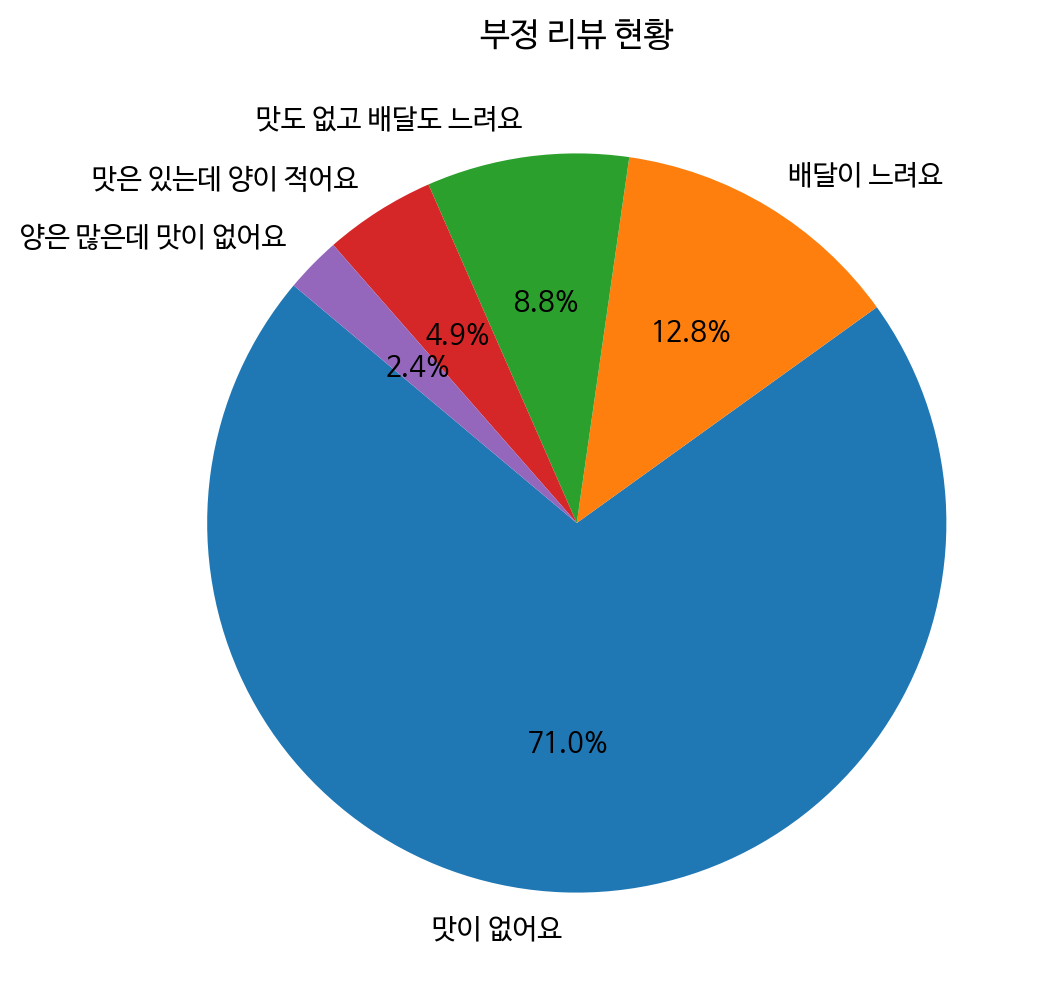

In [137]:
import matplotlib.font_manager
import matplotlib.pyplot as plt

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='NanumBarunGothic')

plt.figure(figsize=(6, 6))

plt.pie(label_counts[:5], labels=label_counts[:5].index, autopct='%1.1f%%', startangle=140)
plt.title('부정 리뷰 현황')
plt.show()

# 다른 방법?

In [43]:
!pip install kiwipiepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kiwipiepy-model: filename=kiwipiepy_model-0.16.0-py3-none-any.whl size=30813255 sha256=d1278b6343a7a2191a887e56f9fcb79a12d9b63bab7fc788b5238a298f2a2999
  Stored in directory: /root/.cache/pip/wheels/6b/03/2b/ac2c97cc65ebd9df3516f4b900adc2f0a744df8d1375b2e2ef
Successfully built kiwipiepy-model


In [44]:
from kiwipiepy import Kiwi

kiwi = Kiwi()

In [45]:
!pip install keybert

  Preparing metadata (setup.py) ... done
  Created wheel for keybert: filename=keybert-0.7.0-py3-none-any.whl size=23765 sha256=85e4132677e18b6a59910cd8782949055093afa22877f88cf4cfa96ecbdc1a81
  Stored in directory: /root/.cache/pip/wheels/66/8d/e6/b0e2f8d883b0fd51819226f67ad9843e04913ce4a97241ff4b
Successfully built keybert


In [46]:
from keybert import KeyBERT

kw_model = KeyBERT()

In [ ]:
text = '맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬래요'

In [ ]:
review_kiwi = kiwi.analyze(text)
review_kiwi

[([Token(form='맛', tag='NNG', start=0, len=1),
   Token(form='이', tag='JKS', start=1, len=1),
   Token(form='별로', tag='MAG', start=3, len=2),
   Token(form='이', tag='VCP', start=5, len=1),
   Token(form='었', tag='EP', start=5, len=1),
   Token(form='어요', tag='EC', start=6, len=2),
   Token(form=',', tag='SP', start=8, len=1),
   Token(form='음식', tag='NNG', start=10, len=2),
   Token(form='이', tag='JKS', start=12, len=1),
   Token(form='촉촉', tag='XR', start=14, len=2),
   Token(form='하', tag='XSA', start=16, len=1),
   Token(form='지', tag='EC', start=17, len=1),
   Token(form='않', tag='VX', start=19, len=1),
   Token(form='고', tag='EC', start=20, len=1),
   Token(form='식', tag='VV', start=22, len=1),
   Token(form='어서', tag='EC', start=23, len=2),
   Token(form='먹', tag='VV', start=26, len=1),
   Token(form='기', tag='ETN', start=27, len=1),
   Token(form='가', tag='JKS', start=28, len=1),
   Token(form='좀', tag='MAG', start=30, len=1),
   Token(form='그렇', tag='VA', start=32, len=2),
   T

In [ ]:
user_results = []
for token, pos, _, _ in review_kiwi[0][0]:
    if pos in ['NNG', 'MAG', 'VA', 'VV', 'VX', 'XR']:  # 일반명사, 형용사, 동사, 어근
            user_results.append(token)
print(user_results)

['맛', '별로', '음식', '촉촉', '않', '식', '먹', '좀', '그렇', '다음', '안', '시키']


In [ ]:
keyword = ' '.join(user_results)

## 키위 - 형태소 분석

In [ ]:
kiwi_reviews = []

for review in train['review']:
    results = []
    result = kiwi.analyze(review)
    for token, pos, _, _ in result[0][0]:
        if pos in ['NNG', 'MAG', 'VA', 'VV', 'VX', 'XR']:
            results.append(token)
    kiwi_reviews.append(results)

In [ ]:
train["kiwi_reviews"] = kiwi_reviews

In [ ]:
train

,review,reply,sentiment,kiwi_reviews
0,맛있게 잘 먹었습니다 양도 1인분 같지 않게 많고요 배달로 빨리 왔습니다 반찬도 메...,안녕하세요 푸짐하고 맛있는 맛있게 잘 드셔주신 것 같아 기분 좋습니다 히히 다음에 ...,1,"[맛있, 잘, 먹, 양도, 같, 않, 많, 배달, 빨리, 오, 반찬, 메인, 음식,..."
1,오늘도 역시나 맛있게 잘 먹었습니다,헤헤헤헿 엄지 척 너무 좋아하는 엄지 척 앞으로도 더욱 열심히 만들어볼게요 앞으로도...,1,"[오늘, 역시, 맛있, 잘, 먹]"
2,정말 맛있게 먹었습니다,맛있게 드셨다니 감사합니다 새해 첫 월요일 시작 잘하시고 늘 행복하세요,1,"[정말, 맛있, 먹]"
3,해산물이 상태가 좋지 않고 맛도 별로에요. 깔끔하지 않고 별로였습니다.,안녕하세요. 줄어드는 음식의 양과 맛에 대해 불만을 표시해주셨군요. 이는 매우 안타...,0,"[해산물, 상태, 좋, 않, 맛, 별로, 깔끔, 않, 별로]"
4,"맛있게 먹을 수 있나 기대하고 주문했는데, 별로였어요. 아쉬웠습니다",맛있게 먹을 수 없는 경험을 제공한 점 깊이 반성하고 있습니다. 다음에는 보다 개선...,0,"[맛있, 먹, 있, 기대, 주문, 별로]"
...,...,...,...,...
95,양 엄청 많아서 좋아요,대부분의 ICE 음료를 1리터 대용량 사이즈로 즐길 수 있는 건 저희 봄봄만의 엄청...,1,"[양, 엄청, 많, 좋]"
96,처음 시켜 먹어봤는데 양도 많고 서비스도 좋고 좋아요 자주 시켜 먹을 거 같아요,첫 주문에 고객님 만족드리기 대 성공했나 유 자주 찾아주시면 저는 자주자주 행복할 ...,1,"[처음, 시키, 먹, 보, 양, 많, 서비스, 좋, 좋, 자주, 시키, 먹, 같]"
97,별로 맛있지 않았고 배송이 늦어서 식어서 먹기도 그렇게 좋지 않았어요.,"안녕하세요, 상추가 상한 것 같아 정말 죄송합니다. 저희는 항상 신선한 재료를 사용...",0,"[별로, 맛있, 않, 배송, 늦, 식, 먹, 그렇, 좋, 않]"
98,양도 많고 맛있게 잘 먹었습니다 어묵탕도 진짜 많이 주셨어요,맛있게 드시고 칭찬글로 응원해 주시니 저희도 기분이 가득 오늘 하루도 감사드리며 다...,1,"[양, 많, 맛있, 잘, 먹, 어묵탕, 진짜, 많이, 주]"


In [ ]:
key_model = KeyBERT('paraphrase-multilingual-MiniLM-L12-v2')  #distilbert-base-nli-mean-tokens / paraphrase-multilingual-MiniLM-L12-v2

## DBSCAN

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 문서를 명사 집합으로 보고 문서 리스트로 치환 (tfidfVectorizer 인풋 형태를 맞추기 위해)
text = [" ".join(noun) for noun in train['kiwi_reviews']]

tfidf_vectorizer = TfidfVectorizer(min_df = 3, ngram_range=(1,5))
tfidf_vectorizer.fit(text)
vector = tfidf_vectorizer.transform(text).toarray()

vector = np.array(vector) # Normalizer를 이용해 변환된 벡터

In [ ]:
# DBSCAN Clustering
from sklearn.cluster import DBSCAN
import numpy as np

model = DBSCAN(eps=0.3,min_samples=3, metric = "cosine")
# 거리 계산 식으로는 Cosine distance를 이용
# eps 낮을수록, min_samples 높을수록 군집으로 판단하는 기준이 까다로움
result = model.fit_predict(vector)

print('군집개수 :', result.max())

군집개수 : 10


In [ ]:
train['result'] = result
train

,review,reply,sentiment,kiwi_reviews,result
0,맛있게 잘 먹었습니다 양도 1인분 같지 않게 많고요 배달로 빨리 왔습니다 반찬도 메...,안녕하세요 푸짐하고 맛있는 맛있게 잘 드셔주신 것 같아 기분 좋습니다 히히 다음에 ...,1,"[맛있, 잘, 먹, 양도, 같, 않, 많, 배달, 빨리, 오, 반찬, 메인, 음식,...",0
1,오늘도 역시나 맛있게 잘 먹었습니다,헤헤헤헿 엄지 척 너무 좋아하는 엄지 척 앞으로도 더욱 열심히 만들어볼게요 앞으로도...,1,"[오늘, 역시, 맛있, 잘, 먹]",-1
2,정말 맛있게 먹었습니다,맛있게 드셨다니 감사합니다 새해 첫 월요일 시작 잘하시고 늘 행복하세요,1,"[정말, 맛있, 먹]",1
3,해산물이 상태가 좋지 않고 맛도 별로에요. 깔끔하지 않고 별로였습니다.,안녕하세요. 줄어드는 음식의 양과 맛에 대해 불만을 표시해주셨군요. 이는 매우 안타...,0,"[해산물, 상태, 좋, 않, 맛, 별로, 깔끔, 않, 별로]",2
4,"맛있게 먹을 수 있나 기대하고 주문했는데, 별로였어요. 아쉬웠습니다",맛있게 먹을 수 없는 경험을 제공한 점 깊이 반성하고 있습니다. 다음에는 보다 개선...,0,"[맛있, 먹, 있, 기대, 주문, 별로]",3
...,...,...,...,...,...
95,양 엄청 많아서 좋아요,대부분의 ICE 음료를 1리터 대용량 사이즈로 즐길 수 있는 건 저희 봄봄만의 엄청...,1,"[양, 엄청, 많, 좋]",-1
96,처음 시켜 먹어봤는데 양도 많고 서비스도 좋고 좋아요 자주 시켜 먹을 거 같아요,첫 주문에 고객님 만족드리기 대 성공했나 유 자주 찾아주시면 저는 자주자주 행복할 ...,1,"[처음, 시키, 먹, 보, 양, 많, 서비스, 좋, 좋, 자주, 시키, 먹, 같]",-1
97,별로 맛있지 않았고 배송이 늦어서 식어서 먹기도 그렇게 좋지 않았어요.,"안녕하세요, 상추가 상한 것 같아 정말 죄송합니다. 저희는 항상 신선한 재료를 사용...",0,"[별로, 맛있, 않, 배송, 늦, 식, 먹, 그렇, 좋, 않]",-1
98,양도 많고 맛있게 잘 먹었습니다 어묵탕도 진짜 많이 주셨어요,맛있게 드시고 칭찬글로 응원해 주시니 저희도 기분이 가득 오늘 하루도 감사드리며 다...,1,"[양, 많, 맛있, 잘, 먹, 어묵탕, 진짜, 많이, 주]",-1


In [ ]:
def print_cluster_result(train):
    clusters = []
    counts = []
    top_title = []
    top_noun = []
    for cluster_num in set(result):
        # -1,0은 노이즈 판별이 났거나 클러스터링이 안된 경우
        # if(cluster_num == -1 or cluster_num == 0):
        #     continue
        # else:
            print("cluster num : {}".format(cluster_num))
            temp_df = train[train['result'] == cluster_num] # cluster num 별로 조회
            clusters.append(cluster_num)
            counts.append(len(temp_df))
            top_title.append(temp_df.reset_index()['review'][0])
            top_noun.append(temp_df.reset_index()['kiwi_reviews'][0]) # 군집별 첫번째 기사를 대표기사로 ; tfidf방식
            for title in temp_df['review']:
                print(title) # 제목으로 살펴보자
            print()

    cluster_result = pd.DataFrame({'cluster_num':clusters, 'count':counts, 'top_title':top_title, 'top_noun':top_noun})
    return cluster_result

In [ ]:
print_cluster_result(train)

cluster num : 0
맛있게 잘 먹었습니다 양도 1인분 같지 않게 많고요 배달로 빨리 왔습니다 반찬도 메인 음식과 잘 어울리는 반찬으로 보내주셔서 잘 먹었습니다 또 주문할게요 
양도 많고 맛있고 반찬도 좋아요 
맛있어요 양도 많고 반찬까지 챙겨주는 집 많지 않은데 반찬도 챙겨줘서 좋았어요 앞으로 많이 시켜 먹으려고요 

cluster num : 1
정말 맛있게 먹었습니다
미치겠네요 정말 맛있어서 와 진짜 맛집인 정
월요일을 기다리는 이유입니다 참나물 두부 무침 정말 맛있네요 사장님 

cluster num : 2
해산물이 상태가 좋지 않고 맛도 별로에요. 깔끔하지 않고 별로였습니다. 
맛이 싱겁고 별로였어요
비주얼은 괜찮았는데 맛이 별로였어요. 
맛이 너무 싱겁고 느끼해서 별로였어요. 좀 더 강한 맛이 있었으면 좋았을 텐데.

cluster num : 3
맛있게 먹을 수 있나 기대하고 주문했는데, 별로였어요. 아쉬웠습니다 
맛있게 잘 먹었습니다 
생각보다 양이 더 넉넉하고 계란 밑에 숨겨진 멸치조림까지 해서 맛있게 먹었어요 
대방어 처음 먹어보는데 맛있네요 맛있게 먹었습니다 거북손 서비스 주신 거 맛있게 먹었는데 이제 없어진 건가요 아쉽네요 
잘 먹었어요 또 주문할게요 
여전히 맛있어요 그런데 양은 좀 줄은 것 같아 아쉽네요
신메뉴를 주문했는데 가족이 맛있다고 하였습니다 맛있게 잘 먹었습니다
치즈가 너무 녹아서 맛이 없었어요. 다른곳에서 주문했더니 훨씬 맛있더라구요 
늘 잘 먹고 있어요 다 맛있어요 
맛있게 잘 먹었습니다 
양도 푸짐하게 주시고 맛있게 잘 먹었습니다
맛있습니다 상추 양이 아쉬울 정도네요 제육 비결이 뭔가요 
맛있어요 진한 육수라기보단 맑은 국물인데 다진 양념이 특히 맛있네요
음료가 시원하고 맛있네요 
맛있게 잘 먹었어요 
너 무 맛있게 잘 먹었습니다 
맛있게 잘 먹었습니다 양도 많고 좋아요
스파이시 슈림프 아보카도 샐러드와 쉬림프랩 엄청 맛있어요

cluster num : 4
맛도 양도 배달도 최악이었습니다. 
맛은 그럭저럭 이지만 배달

,cluster_num,count,top_title,top_noun
0,0,3,맛있게 잘 먹었습니다 양도 1인분 같지 않게 많고요 배달로 빨리 왔습니다 반찬도 메...,"[맛있, 잘, 먹, 양도, 같, 않, 많, 배달, 빨리, 오, 반찬, 메인, 음식,..."
1,1,3,정말 맛있게 먹었습니다,"[정말, 맛있, 먹]"
2,2,4,해산물이 상태가 좋지 않고 맛도 별로에요. 깔끔하지 않고 별로였습니다.,"[해산물, 상태, 좋, 않, 맛, 별로, 깔끔, 않, 별로]"
3,3,18,"맛있게 먹을 수 있나 기대하고 주문했는데, 별로였어요. 아쉬웠습니다","[맛있, 먹, 있, 기대, 주문, 별로]"
4,4,3,맛도 양도 배달도 최악이었습니다.,"[맛, 양도, 배달, 최악]"
5,5,4,음식이 살짝 느끼하고 맛이 좀 아쉬웠네요. 다른 음식점에 비해 별로였어요,"[음식, 살짝, 느끼, 맛, 좀, 음식점, 비하, 별로]"
6,6,3,너무 맛있게 잘 먹었어요 다이어트 중이었는데 절반을 먹어버렸어요 양 확 줄었는데 폭...,"[너무, 맛있, 잘, 먹, 다이어트, 절반, 먹, 버리, 확, 줄, 폭식, 맵기, ..."
7,7,6,"배달이 빠르긴 했지만, 맛은 별로였어요. 다음에는 다른 식당에서 시킬 걸 그랬어요","[배달, 빠르, 하, 맛, 별로, 다음, 식당, 시키, 그렇]"
8,8,3,원래 연근은 불호에 가까웠는데 맛나게 구워주신 덕분에 요새는 찾아서 먹어요 늘 맛있...,"[원래, 연근, 불, 맛나, 주, 덕분, 요새, 찾, 먹, 늘, 맛있, 만들, 주,..."
9,9,3,맛도 좋고 배달도 빠르고 좋아요,"[맛, 좋, 배달, 빠르, 좋]"


## K-Means Clustering

In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

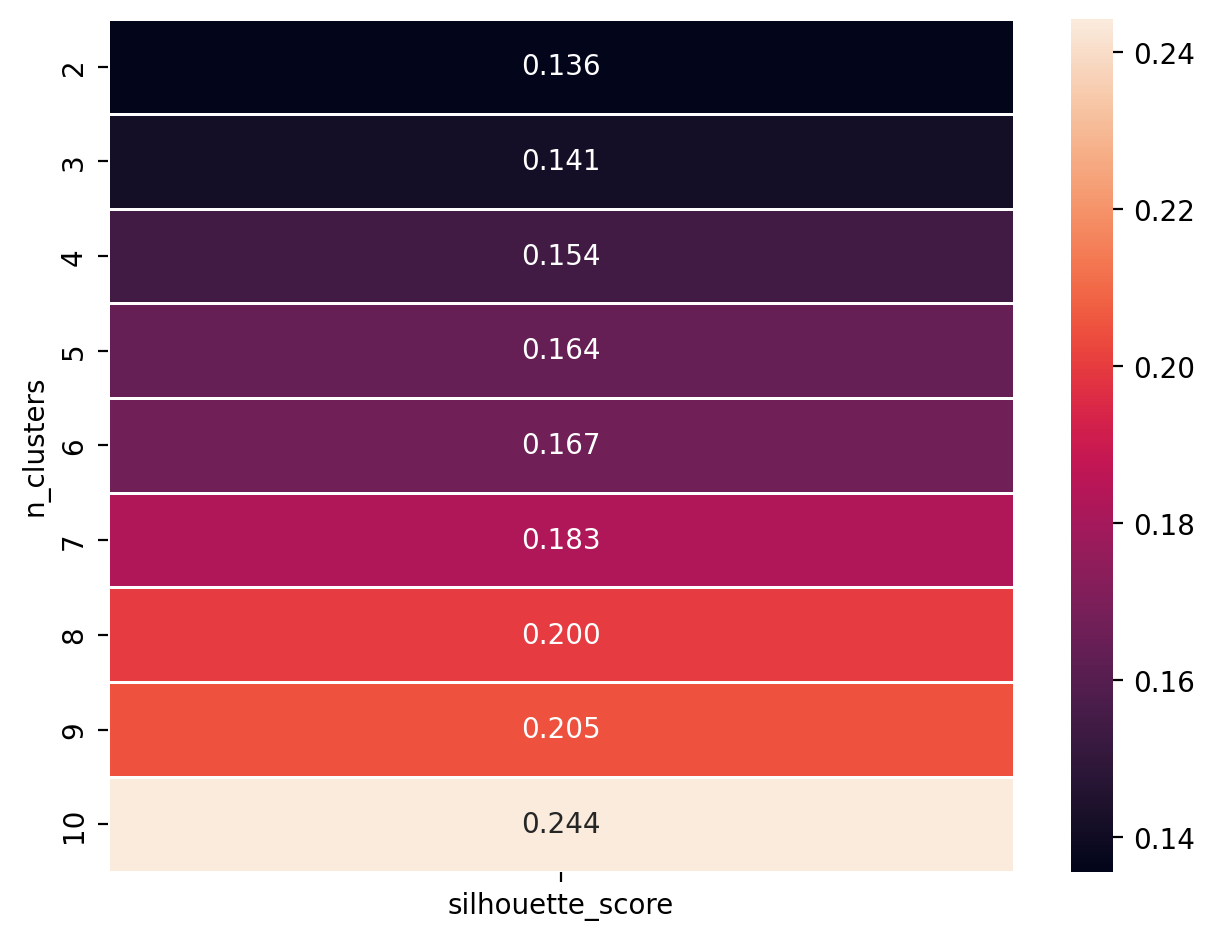

In [ ]:
# Silhouette Score - 최적 k

def visualize_silhouette_layer(data, param_init='random', param_n_init=10, param_max_iter=300):
    clusters_range = range(2,11)
    results = []

    for i in clusters_range:
        clusterer = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()

visualize_silhouette_layer(vector) # 가장 높은 실루엣 계수와 매핑되는 k

In [ ]:
# K-Means Clustering

from sklearn.cluster import KMeans

result_2nd = KMeans(n_clusters=9).fit_predict(vector)
train['kmean'] = result_2nd

# cluster2_result = print_cluster_result( train=cluster1_result,
#                                        result=result_2nd, col_cluster="cluster2nd")

In [ ]:
train

,review,reply,sentiment,kiwi_reviews,result,kmean
0,맛있게 잘 먹었습니다 양도 1인분 같지 않게 많고요 배달로 빨리 왔습니다 반찬도 메...,안녕하세요 푸짐하고 맛있는 맛있게 잘 드셔주신 것 같아 기분 좋습니다 히히 다음에 ...,1,"[맛있, 잘, 먹, 양도, 같, 않, 많, 배달, 빨리, 오, 반찬, 메인, 음식,...",0,8
1,오늘도 역시나 맛있게 잘 먹었습니다,헤헤헤헿 엄지 척 너무 좋아하는 엄지 척 앞으로도 더욱 열심히 만들어볼게요 앞으로도...,1,"[오늘, 역시, 맛있, 잘, 먹]",-1,1
2,정말 맛있게 먹었습니다,맛있게 드셨다니 감사합니다 새해 첫 월요일 시작 잘하시고 늘 행복하세요,1,"[정말, 맛있, 먹]",1,1
3,해산물이 상태가 좋지 않고 맛도 별로에요. 깔끔하지 않고 별로였습니다.,안녕하세요. 줄어드는 음식의 양과 맛에 대해 불만을 표시해주셨군요. 이는 매우 안타...,0,"[해산물, 상태, 좋, 않, 맛, 별로, 깔끔, 않, 별로]",2,7
4,"맛있게 먹을 수 있나 기대하고 주문했는데, 별로였어요. 아쉬웠습니다",맛있게 먹을 수 없는 경험을 제공한 점 깊이 반성하고 있습니다. 다음에는 보다 개선...,0,"[맛있, 먹, 있, 기대, 주문, 별로]",3,0
...,...,...,...,...,...,...
95,양 엄청 많아서 좋아요,대부분의 ICE 음료를 1리터 대용량 사이즈로 즐길 수 있는 건 저희 봄봄만의 엄청...,1,"[양, 엄청, 많, 좋]",-1,1
96,처음 시켜 먹어봤는데 양도 많고 서비스도 좋고 좋아요 자주 시켜 먹을 거 같아요,첫 주문에 고객님 만족드리기 대 성공했나 유 자주 찾아주시면 저는 자주자주 행복할 ...,1,"[처음, 시키, 먹, 보, 양, 많, 서비스, 좋, 좋, 자주, 시키, 먹, 같]",-1,1
97,별로 맛있지 않았고 배송이 늦어서 식어서 먹기도 그렇게 좋지 않았어요.,"안녕하세요, 상추가 상한 것 같아 정말 죄송합니다. 저희는 항상 신선한 재료를 사용...",0,"[별로, 맛있, 않, 배송, 늦, 식, 먹, 그렇, 좋, 않]",-1,7
98,양도 많고 맛있게 잘 먹었습니다 어묵탕도 진짜 많이 주셨어요,맛있게 드시고 칭찬글로 응원해 주시니 저희도 기분이 가득 오늘 하루도 감사드리며 다...,1,"[양, 많, 맛있, 잘, 먹, 어묵탕, 진짜, 많이, 주]",-1,1


In [ ]:
# 엑셀로 확인
with pd.ExcelWriter("군집화.xlsx", engine='openpyxl') as writer:
    train.to_excel(writer, sheet_name='시트1', index=False)

## 서비스1 허깅페이스 모델 사용(Zero-Shot Classification)

In [19]:
!pip install transformers

In [20]:
!pip install sentencepiece

In [21]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

# 모델과 토크나이저 초기화
model_name = "MoritzLaurer/mDeBERTa-v3-base-mnli-xnli"
# model_name = "sileod/mdeberta-v3-base-tasksource-nli"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [22]:
# 제로샷 분류 파이프라인 초기화
classifier = pipeline("zero-shot-classification", model=model, tokenizer=tokenizer)  # GPU 사용 설정

# 분류를 위한 레이블 목록
candidate_labels = ['맛있음', '맛없음', '양 적음', '양 많음', '빠른 배달', '느린 배달']

# 전체 리뷰에 대해 제로샷 분류 수행
labels_collected = []
scores_collected = []

for review in tqdm(train['review']):  # 전체 데이터 처리
    output = classifier(review, candidate_labels, multi_label=True)
    labels = [label for label, score in zip(output['labels'], output['scores']) if score > 0.7]
    scores = [round(score, 2) for score in output['scores']]

    labels_collected.append(', '.join(labels))
    scores_collected.append(', '.join([f"{label}: {round(score, 2)}" for label, score in zip(output['labels'], output['scores'])]))

# 결과를 데이터프레임으로 변환
result_df = pd.DataFrame({
    'Review': train['review'],
    'Label': labels_collected,
    'Label-Scores': scores_collected
})

  0%|          | 0/100 [00:00<?, ?it/s]

- MoritzLaurer

In [23]:
result_df

,Review,Label,Label-Scores
0,맛있게 잘 먹었습니다 양도 1인분 같지 않게 많고요 배달로 빨리 왔습니다 반찬도 메...,"빠른 배달, 맛있음, 양 많음","빠른 배달: 1.0, 맛있음: 1.0, 양 많음: 0.99, 느린 배달: 0.31,..."
1,오늘도 역시나 맛있게 잘 먹었습니다,맛있음,"맛있음: 1.0, 양 많음: 0.54, 빠른 배달: 0.26, 양 적음: 0.22,..."
2,정말 맛있게 먹었습니다,맛있음,"맛있음: 0.99, 양 많음: 0.33, 양 적음: 0.16, 빠른 배달: 0.15..."
3,해산물이 상태가 좋지 않고 맛도 별로에요. 깔끔하지 않고 별로였습니다.,"맛없음, 양 많음, 양 적음","맛없음: 1.0, 양 많음: 1.0, 양 적음: 1.0, 느린 배달: 0.68, 빠..."
4,"맛있게 먹을 수 있나 기대하고 주문했는데, 별로였어요. 아쉬웠습니다","맛없음, 양 적음","맛없음: 1.0, 양 적음: 0.76, 느린 배달: 0.67, 양 많음: 0.46,..."
...,...,...,...
95,양 엄청 많아서 좋아요,"맛있음, 양 많음","맛있음: 1.0, 양 많음: 1.0, 빠른 배달: 0.63, 느린 배달: 0.0, ..."
96,처음 시켜 먹어봤는데 양도 많고 서비스도 좋고 좋아요 자주 시켜 먹을 거 같아요,"양 많음, 맛있음, 빠른 배달","양 많음: 0.99, 맛있음: 0.99, 빠른 배달: 0.73, 양 적음: 0.0,..."
97,별로 맛있지 않았고 배송이 늦어서 식어서 먹기도 그렇게 좋지 않았어요.,"맛없음, 느린 배달, 양 적음","맛없음: 1.0, 느린 배달: 1.0, 양 적음: 0.94, 양 많음: 0.5, 빠..."
98,양도 많고 맛있게 잘 먹었습니다 어묵탕도 진짜 많이 주셨어요,"맛있음, 양 많음","맛있음: 1.0, 양 많음: 1.0, 빠른 배달: 0.16, 느린 배달: 0.0, ..."


In [24]:
# 엑셀로 확인
with pd.ExcelWriter("MoritzLaurer_군집화.xlsx", engine='openpyxl') as writer:
    result_df.to_excel(writer, sheet_name='시트1', index=False)

- sileod

In [ ]:
result_df

,Review,Label,Label-Scores
0,맛있게 잘 먹었습니다 양도 1인분 같지 않게 많고요 배달로 빨리 왔습니다 반찬도 메...,"빠른 배달, 많은 양, 맛있음, 느린 배달","빠른 배달: 1.0, 많은 양: 0.99, 맛있음: 0.98, 느린 배달: 0.91..."
1,오늘도 역시나 맛있게 잘 먹었습니다,"맛있음, 빠른 배달, 많은 양, 적은 양","맛있음: 0.98, 빠른 배달: 0.97, 많은 양: 0.96, 적은 양: 0.55..."
2,정말 맛있게 먹었습니다,"맛있음, 빠른 배달, 많은 양","맛있음: 0.98, 빠른 배달: 0.94, 많은 양: 0.83, 적은 양: 0.22..."
3,해산물이 상태가 좋지 않고 맛도 별로에요. 깔끔하지 않고 별로였습니다.,"맛없음, 많은 양","맛없음: 0.66, 많은 양: 0.6, 적은 양: 0.44, 느린 배달: 0.33,..."
4,"맛있게 먹을 수 있나 기대하고 주문했는데, 별로였어요. 아쉬웠습니다",맛없음,"맛없음: 0.77, 느린 배달: 0.29, 많은 양: 0.2, 적은 양: 0.19,..."
...,...,...,...
95,양 엄청 많아서 좋아요,"많은 양, 맛있음, 빠른 배달","많은 양: 0.99, 맛있음: 0.98, 빠른 배달: 0.91, 느린 배달: 0.1..."
96,처음 시켜 먹어봤는데 양도 많고 서비스도 좋고 좋아요 자주 시켜 먹을 거 같아요,"많은 양, 빠른 배달, 맛있음","많은 양: 1.0, 빠른 배달: 0.99, 맛있음: 0.99, 적은 양: 0.25,..."
97,별로 맛있지 않았고 배송이 늦어서 식어서 먹기도 그렇게 좋지 않았어요.,"느린 배달, 맛없음, 많은 양","느린 배달: 0.98, 맛없음: 0.85, 많은 양: 0.54, 적은 양: 0.35..."
98,양도 많고 맛있게 잘 먹었습니다 어묵탕도 진짜 많이 주셨어요,"많은 양, 맛있음, 빠른 배달","많은 양: 1.0, 맛있음: 0.99, 빠른 배달: 0.98, 느린 배달: 0.08..."


## sentence transformers

- https://www.infoking.site/52

In [ ]:
doc_list = train['review'].to_list()

In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('paraphrase-distilroberta-base-v1')

embeddings = model.encode(doc_list, convert_to_tensor=True)


In [ ]:
target = sim_cluster_label['label'].to_list()
target_embeddings = model.encode(target, convert_to_tensor=True)

In [ ]:
cosine_scores = util.pytorch_cos_sim(target_embeddings, embeddings)

In [ ]:
org = 0
temp = cosine_scores[org]
temp.argsort(descending=True)[0:50] # 상위 10개 정렬 후 출력

for i in temp.argsort(descending=True)[0:50]:
    print(f"{i}. {target[org]} <> {doc_list[i]} \nScore: {cosine_scores[org][i]:.4f}")

5. 맛이 없어요 <> 맛이 싱겁고 별로였어요 
Score: 0.9084
83. 맛이 없어요 <> 맛이 별로였어요. 가격대비 너무 아쉬웠어요  
Score: 0.8919
6. 맛이 없어요 <> 맛이 전혀 좋지 않았어요. 다른 음식점을 찾아봐야겠어요  
Score: 0.8858
39. 맛이 없어요 <> 맛도 별로고 배달이 너무 늦었어요.  
Score: 0.8715
87. 맛이 없어요 <> 맛이 너무 떨어지고 식감도 별로였어요. 다음에는 다른 가게에서 시킬게요  
Score: 0.8693
45. 맛이 없어요 <> 맛이 너무 싱겁고 느끼해서 별로였어요. 좀 더 강한 맛이 있었으면 좋았을 텐데. 
Score: 0.8691
31. 맛이 없어요 <> 맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬 거 같아요  
Score: 0.8627
66. 맛이 없어요 <> 맛이 없고 특별한 게 없어서 실망스러웠어요. 다른 곳에서 먹을 걸 그랬어요  
Score: 0.8607
88. 맛이 없어요 <> 음식이 맛있지 않았어요. 향이 좀 이상해서 입맛에 맞지 않았어요.  
Score: 0.8447
82. 맛이 없어요 <> 음식이 맛없고 배달이 늦었어요. 이 가격에 이런 질을 보이다니 정말 아쉬워요  
Score: 0.8430
42. 맛이 없어요 <> 맛은 그럭저럭 이지만 배달 비용이 비싸서 좀 아쉬웠습니다. 다른 곳을 찾아보려고 생각중이에요  
Score: 0.8427
63. 맛이 없어요 <> 맛이 별로였어요, 음식이 너무 달았고, 너무 식어서 먹기가 좀 그랬어요. 다시 시키지 않을 거 같아요.  
Score: 0.8427
26. 맛이 없어요 <> 음식이 맛이 없었고, 배달이 너무 늦게 왔습니다. 다시는 시키지 않을 거에요.  
Score: 0.8416
58. 맛이 없어요 <> 맛이 별로였어요, 음식이 질이 좋지 않아서 먹는데도 좀 그랬어요. 다음에는 다른 식당에서 시킬거에요  
Score: 0.8383
73. 맛이 없어요 <> 맛도 별로고 배달도 늦

In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')


sentences = ['맛이 별로였어요.배달도 오래 걸렸네요', '맛있어요', '맛없어요','양이 적어요','양이 많아요','빠른 배달','느린 배달']
vectors = model.encode(sentences) # encode sentences into vectors

similarities = util.cos_sim(vectors, vectors) # compute similarity between sentence vectors
print(similarities)

tensor([[1.0000, 0.3637, 0.6374, 0.4571, 0.2570, 0.5213, 0.5992],
        [0.3637, 1.0000, 0.6292, 0.3167, 0.4616, 0.3986, 0.2338],
        [0.6374, 0.6292, 1.0000, 0.4920, 0.3438, 0.2774, 0.3273],
        [0.4571, 0.3167, 0.4920, 1.0000, 0.7916, 0.2252, 0.2591],
        [0.2570, 0.4616, 0.3438, 0.7916, 1.0000, 0.2746, 0.1775],
        [0.5213, 0.3986, 0.2774, 0.2252, 0.2746, 1.0000, 0.9011],
        [0.5992, 0.2338, 0.3273, 0.2591, 0.1775, 0.9011, 1.0000]])


## jhgan/ko-sroberta-multitask

In [37]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

embedder = SentenceTransformer("jhgan/ko-sroberta-multitask")

# Corpus with example sentences
corpus = ['오늘도 역시나 맛있게 잘 먹었습니다',
'해산물이 상태가 좋지 않고 맛도 별로에요. 깔끔하지 않고 별로였습니다.',
'너무 싱숭해서 좀 실망했습니다. 이번 경험 후로는 시키지 않을 거예요 ',
'신메뉴를 주문했는데 가족이 맛있다고 하였습니다 맛있게 잘 먹었습니다',
'배달이 늦어서 음식이 다 식었어요',
'양이 넘 많아서 남겼어요.',
'배달이 좀 늦어졌어요. 식사시간이 지나서 배고플 때 받게 되어서 아쉬웠어요.']

corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)

# Query sentences:
queries = ['맛이 없어요',
           '양이 적어요' ,
	       '배달이 느려요',
	       '맛있어요',
            '양이 많아요',
           '배달이 빨라요']

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = 2
for query in queries:
 query_embedding = embedder.encode(query, convert_to_tensor=True)
 cos_scores = util.pytorch_cos_sim(query_embedding, corpus_embeddings)[0]
 cos_scores = cos_scores.cpu()

 #We use np.argpartition, to only partially sort the top_k results
 top_results = np.argpartition(-cos_scores, range(top_k))[0:top_k]

 print("\n\n======================\n\n")
 print("Query:", query)
 print("\nTop 5 most similar sentences in corpus:")

 for idx in top_results[0:top_k]:
  print(corpus[idx].strip(), "(Score: %.4f)" % (cos_scores[idx]))





Query: 맛이 없어요

Top 5 most similar sentences in corpus:
해산물이 상태가 좋지 않고 맛도 별로에요. 깔끔하지 않고 별로였습니다. (Score: 0.6215)
너무 싱숭해서 좀 실망했습니다. 이번 경험 후로는 시키지 않을 거예요 (Score: 0.3320)




Query: 양이 적어요

Top 5 most similar sentences in corpus:
양이 넘 많아서 남겼어요. (Score: 0.3388)
해산물이 상태가 좋지 않고 맛도 별로에요. 깔끔하지 않고 별로였습니다. (Score: 0.3237)




Query: 배달이 느려요

Top 5 most similar sentences in corpus:
배달이 좀 늦어졌어요. 식사시간이 지나서 배고플 때 받게 되어서 아쉬웠어요. (Score: 0.6077)
배달이 늦어서 음식이 다 식었어요 (Score: 0.5563)




Query: 맛있어요

Top 5 most similar sentences in corpus:
오늘도 역시나 맛있게 잘 먹었습니다 (Score: 0.6234)
신메뉴를 주문했는데 가족이 맛있다고 하였습니다 맛있게 잘 먹었습니다 (Score: 0.5667)




Query: 양이 많아요

Top 5 most similar sentences in corpus:
양이 넘 많아서 남겼어요. (Score: 0.7488)
오늘도 역시나 맛있게 잘 먹었습니다 (Score: 0.4165)




Query: 배달이 빨라요

Top 5 most similar sentences in corpus:
배달이 좀 늦어졌어요. 식사시간이 지나서 배고플 때 받게 되어서 아쉬웠어요. (Score: 0.4109)
배달이 늦어서 음식이 다 식었어요 (Score: 0.3383)


In [41]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

embedder = SentenceTransformer("jhgan/ko-sroberta-multitask")

# Query sentences:
queries = ['맛이 없어요',
           '양이 적어요' ,
	       '배달이 느려요',
	       '맛있어요',
            '양이 많아요',
           '배달이 빨라요']

result = []
for query in tqdm(queries):
    for review in train['review']:
        review_embeddings = embedder.encode(review, convert_to_tensor=True)
        query_embedding = embedder.encode(query, convert_to_tensor=True)
        cos_scores = util.pytorch_cos_sim(query_embedding, review_embeddings)[0]
        cos_scores = cos_scores.cpu()

        if cos_scores >= 0.6:
            result.append({'label': query, 'review': review, 'score': cos_scores})

result = pd.DataFrame(result)
result

  0%|          | 0/6 [00:00<?, ?it/s]

,label,review,score
0,맛이 없어요,해산물이 상태가 좋지 않고 맛도 별로에요. 깔끔하지 않고 별로였습니다.,[tensor(0.6215)]
1,맛이 없어요,맛이 싱겁고 별로였어요,[tensor(0.6646)]
2,맛이 없어요,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",[tensor(0.6363)]
3,맛이 없어요,이번에 시켜먹은 음식은 정말 싱겁고 맛이 없어서 실망스러웠어요,[tensor(0.6166)]
4,맛이 없어요,"딱히 맛있지 않았어요, 음식이 썩 맛있게 느껴지지 않았어요. 실망스러워요",[tensor(0.6142)]
5,맛이 없어요,맛이 너무 떨어지고 식감도 별로였어요. 다음에는 다른 가게에서 시킬게요,[tensor(0.6239)]
6,맛이 없어요,음식이 맛있지 않았어요. 향이 좀 이상해서 입맛에 맞지 않았어요.,[tensor(0.6251)]
7,양이 적어요,여전히 맛있어요 그런데 양은 좀 줄은 것 같아 아쉽네요,[tensor(0.6226)]
8,양이 적어요,양이 너무 적고 서비스도 별로였어요.,[tensor(0.6186)]
9,배달이 느려요,배달이 너무 늦어서 실망했어요. 시간을 정확히 지키지 않았어요.,[tensor(0.6354)]


In [42]:
# 엑셀로 확인
with pd.ExcelWriter("0923_result.xlsx", engine='openpyxl') as writer:
    result.to_excel(writer, sheet_name='시트1', index=False)